In [5]:
from src.degradations.gaussian_noise import add_gaussian_noise

# Test Gaussian Noise Degradation

Questo notebook testa la degradazione con rumore Gaussiano

In [6]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [7]:
# Carica immagine reale dal dataset DIV2K
image_path = Path('../data/raw/DIV2K_train_HR/0001.png')

if image_path.exists():
    # Carica e converti da BGR a RGB
    test_image = cv2.imread(str(image_path))
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    # Ridimensiona per velocità (mantieni aspect ratio)
    h, w = test_image.shape[:2]
    max_size = 512
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        test_image = cv2.resize(test_image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    
    print(f"✅ Immagine caricata: {image_path.name}")
    print(f"   Shape: {test_image.shape}")
    print(f"   Range valori: [{test_image.min()}, {test_image.max()}]")
    print(f"   Dtype: {test_image.dtype}")
else:
    print(f"❌ Immagine non trovata: {image_path}")

✅ Immagine caricata: 0001.png
   Shape: (352, 512, 3)
   Range valori: [0, 251]
   Dtype: uint8


In [11]:
# Applica rumore Gaussiano con diversi livelli di sigma
sigma_values = [10, 25, 50, 75, 100]
noisy_images = {}

for sigma in sigma_values:
    noisy = add_gaussian_noise(test_image, sigma=sigma, seed=42)
    noisy_images[sigma] = noisy
    print(f"Sigma={sigma}: range [{noisy.min()}, {noisy.max()}]")

Sigma=10: range [0, 255]
Sigma=25: range [0, 255]
Sigma=50: range [0, 255]
Sigma=75: range [0, 255]
Sigma=100: range [0, 255]


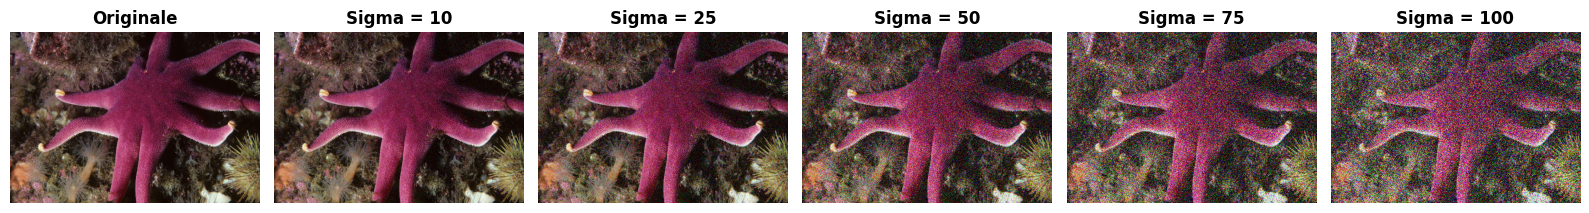

In [13]:
# Visualizza i risultati
fig, axes = plt.subplots(1, len(sigma_values) + 1, figsize=(16, 4))

# Immagine originale
axes[0].imshow(test_image)
axes[0].set_title('Originale', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Immagini con rumore
for idx, sigma in enumerate(sigma_values):
    axes[idx + 1].imshow(noisy_images[sigma])
    axes[idx + 1].set_title(f'Sigma = {sigma}', fontsize=12, fontweight='bold')
    axes[idx + 1].axis('off')

plt.tight_layout()
plt.show()

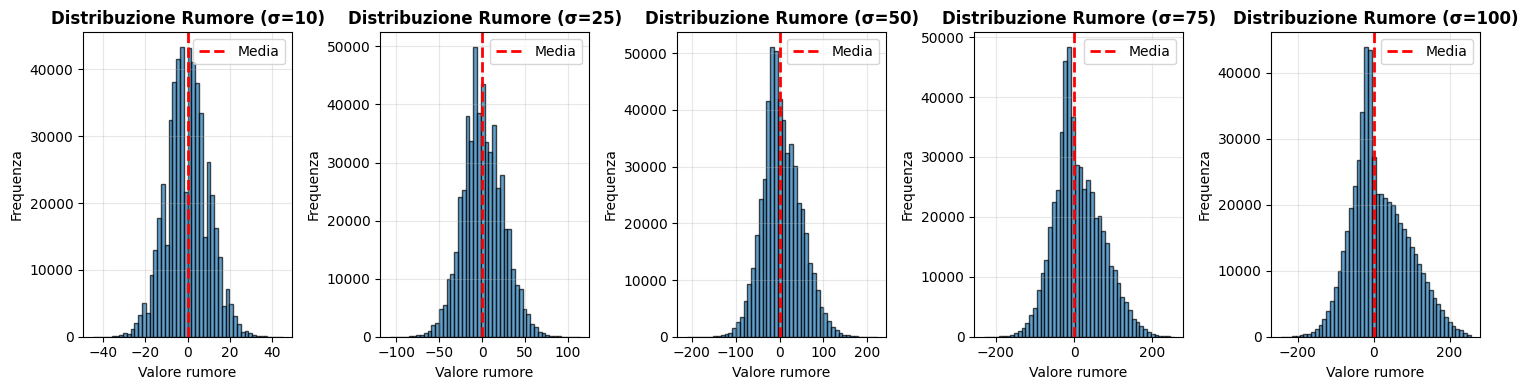


📊 Statistiche del rumore aggiunto:

Sigma = 10:
  Media: -0.35
  Std Dev: 9.80
  Min: -45.00
  Max: 45.00

Sigma = 25:
  Media: 0.76
  Std Dev: 23.43
  Min: -108.00
  Max: 114.00

Sigma = 50:
  Media: 4.51
  Std Dev: 43.56
  Min: -212.00
  Max: 221.00

Sigma = 75:
  Media: 9.70
  Std Dev: 60.55
  Min: -231.00
  Max: 254.00

Sigma = 100:
  Media: 15.24
  Std Dev: 74.25
  Min: -245.00
  Max: 255.00


In [15]:
# Analisi statistica del rumore
fig, axes = plt.subplots(1, len(sigma_values), figsize=(15, 4))

for idx, sigma in enumerate(sigma_values):
    # Calcola la differenza (il rumore aggiunto)
    noise = noisy_images[sigma].astype(float) - test_image.astype(float)
    
    # Istogramma del rumore
    axes[idx].hist(noise.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribuzione Rumore (σ={sigma})', fontweight='bold')
    axes[idx].set_xlabel('Valore rumore')
    axes[idx].set_ylabel('Frequenza')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Media')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche
print("\n📊 Statistiche del rumore aggiunto:")
for sigma in sigma_values:
    noise = noisy_images[sigma].astype(float) - test_image.astype(float)
    print(f"\nSigma = {sigma}:")
    print(f"  Media: {noise.mean():.2f}")
    print(f"  Std Dev: {noise.std():.2f}")
    print(f"  Min: {noise.min():.2f}")
    print(f"  Max: {noise.max():.2f}")

## Effetto del Clipping sul Rumore

Il rumore generato è gaussiano, ma quando viene applicato l'immagine viene clippata a [0, 255], distorcendo la distribuzione finale.

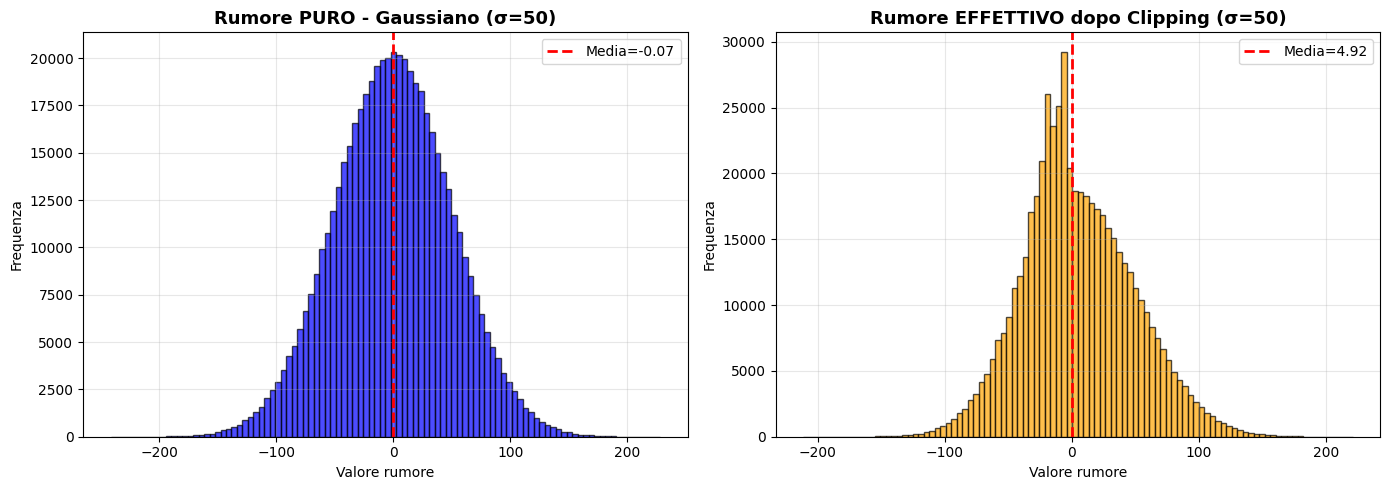

📊 Confronto statistiche:

Rumore PURO (prima del clipping):
  Media: -0.0695
  Std Dev: 50.0268
  Min: -241.47
  Max: 228.11

Rumore EFFETTIVO (dopo il clipping):
  Media: 4.9201
  Std Dev: 43.6201
  Min: -211.36
  Max: 221.00

⚠️  Il clipping distorce la distribuzione!
   - Media si sposta da ~0 a 4.9201
   - Std Dev si riduce da 50.03 a 43.62


In [16]:
# Confronto: rumore puro vs rumore dopo clipping
import numpy as np

sigma_test = 50

# Genera rumore puro (gaussiano perfetto)
np.random.seed(42)
pure_noise = np.random.randn(*test_image.shape) * sigma_test

# Applica rumore e clippa
noisy_clipped = np.clip(test_image.astype(float) + pure_noise, 0, 255)

# Rumore "effettivo" dopo il clipping
effective_noise = noisy_clipped - test_image.astype(float)

# Visualizza confronto
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rumore puro (gaussiano)
axes[0].hist(pure_noise.flatten(), bins=100, alpha=0.7, edgecolor='black', color='blue')
axes[0].set_title(f'Rumore PURO - Gaussiano (σ={sigma_test})', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Valore rumore')
axes[0].set_ylabel('Frequenza')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label=f'Media={pure_noise.mean():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Rumore effettivo (dopo clipping)
axes[1].hist(effective_noise.flatten(), bins=100, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title(f'Rumore EFFETTIVO dopo Clipping (σ={sigma_test})', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Valore rumore')
axes[1].set_ylabel('Frequenza')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label=f'Media={effective_noise.mean():.2f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Confronto statistiche:")
print(f"\nRumore PURO (prima del clipping):")
print(f"  Media: {pure_noise.mean():.4f}")
print(f"  Std Dev: {pure_noise.std():.4f}")
print(f"  Min: {pure_noise.min():.2f}")
print(f"  Max: {pure_noise.max():.2f}")

print(f"\nRumore EFFETTIVO (dopo il clipping):")
print(f"  Media: {effective_noise.mean():.4f}")
print(f"  Std Dev: {effective_noise.std():.4f}")
print(f"  Min: {effective_noise.min():.2f}")
print(f"  Max: {effective_noise.max():.2f}")

print(f"\n⚠️  Il clipping distorce la distribuzione!")
print(f"   - Media si sposta da ~0 a {effective_noise.mean():.4f}")
print(f"   - Std Dev si riduce da {pure_noise.std():.2f} a {effective_noise.std():.2f}")

## Perché l'Asimmetria?

Dipende dalla **distribuzione dei pixel nell'immagine originale**!

In [17]:
# Esempio pratico: come funziona il clipping
print("🔍 Esempio di come il clipping distorce il rumore:\n")

# Pixel di esempio con rumore
examples = [
    ("Pixel scuro", 20, -80),   # Pixel scuro con rumore negativo forte
    ("Pixel medio", 128, -80),  # Pixel medio con rumore negativo forte  
    ("Pixel chiaro", 240, -80), # Pixel chiaro con rumore negativo forte
    ("Pixel scuro", 20, +80),   # Pixel scuro con rumore positivo forte
    ("Pixel medio", 128, +80),  # Pixel medio con rumore positivo forte
    ("Pixel chiaro", 240, +80), # Pixel chiaro con rumore positivo forte
]

print(f"{'Tipo':<15} {'Pixel orig.':<12} {'Rumore':<10} {'Pixel+Rumore':<15} {'Dopo Clip':<12} {'Rumore effettivo':<18}")
print("-" * 95)

for desc, pixel_val, noise_val in examples:
    pixel_plus_noise = pixel_val + noise_val
    clipped = np.clip(pixel_plus_noise, 0, 255)
    effective = clipped - pixel_val
    clipped_marker = " ⚠️ CLIPPATO!" if (pixel_plus_noise < 0 or pixel_plus_noise > 255) else ""
    
    print(f"{desc:<15} {pixel_val:<12} {noise_val:+<10} {pixel_plus_noise:<15} {int(clipped):<12} {effective:+.0f}{clipped_marker}")

print("\n💡 Conclusione:")
print("   - Pixel SCURI (vicini a 0): subiscono clipping con rumore NEGATIVO → perdono intensità negativa")
print("   - Pixel CHIARI (vicini a 255): subiscono clipping con rumore POSITIVO → perdono intensità positiva")
print("\n   Se l'immagine ha più pixel scuri → più clipping a SINISTRA (valori negativi tagliati)")
print("   Se l'immagine ha più pixel chiari → più clipping a DESTRA (valori positivi tagliati)")

🔍 Esempio di come il clipping distorce il rumore:

Tipo            Pixel orig.  Rumore     Pixel+Rumore    Dopo Clip    Rumore effettivo  
-----------------------------------------------------------------------------------------------
Pixel scuro     20           -80+++++++ -60             0            -20 ⚠️ CLIPPATO!
Pixel medio     128          -80+++++++ 48              48           -80
Pixel chiaro    240          -80+++++++ 160             160          -80
Pixel scuro     20           80++++++++ 100             100          +80
Pixel medio     128          80++++++++ 208             208          +80
Pixel chiaro    240          80++++++++ 320             255          +15 ⚠️ CLIPPATO!

💡 Conclusione:
   - Pixel SCURI (vicini a 0): subiscono clipping con rumore NEGATIVO → perdono intensità negativa
   - Pixel CHIARI (vicini a 255): subiscono clipping con rumore POSITIVO → perdono intensità positiva

   Se l'immagine ha più pixel scuri → più clipping a SINISTRA (valori negativi tagl

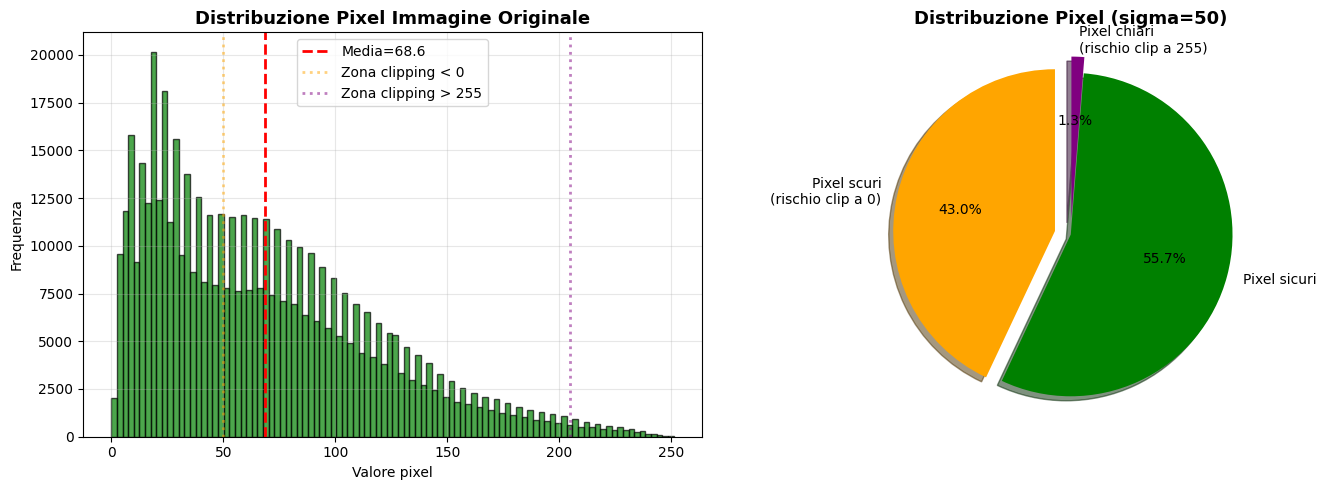


📊 Analisi immagine originale:
   Media pixel: 68.6
   Std Dev: 49.5

   Con sigma=50:
   - Pixel < 50 (rischio clip a 0): 232,463 (43.0%)
   - Pixel > 205 (rischio clip a 255): 6,911 (1.3%)

   → Più pixel scuri = più clipping NEGATIVO = asimmetria verso SINISTRA!


In [18]:
# Verifica: distribuzione pixel dell'immagine originale
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma pixel originali
axes[0].hist(test_image.flatten(), bins=100, alpha=0.7, edgecolor='black', color='green')
axes[0].set_title('Distribuzione Pixel Immagine Originale', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Valore pixel')
axes[0].set_ylabel('Frequenza')
axes[0].axvline(test_image.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Media={test_image.mean():.1f}')
axes[0].axvline(50, color='orange', linestyle=':', linewidth=2, alpha=0.5, label='Zona clipping < 0')
axes[0].axvline(205, color='purple', linestyle=':', linewidth=2, alpha=0.5, label='Zona clipping > 255')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Conta pixel in zone critiche
pixels_dark = np.sum(test_image < 50)  # Pixel che rischiano clipping a 0 con sigma=50
pixels_bright = np.sum(test_image > 205)  # Pixel che rischiano clipping a 255 con sigma=50
pixels_safe = np.sum((test_image >= 50) & (test_image <= 205))

# Grafico a torta
labels = ['Pixel scuri\n(rischio clip a 0)', 'Pixel sicuri', 'Pixel chiari\n(rischio clip a 255)']
sizes = [pixels_dark, pixels_safe, pixels_bright]
colors = ['orange', 'green', 'purple']
explode = (0.1, 0, 0.1)

axes[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
axes[1].set_title(f'Distribuzione Pixel (sigma={sigma_test})', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

print(f"\n📊 Analisi immagine originale:")
print(f"   Media pixel: {test_image.mean():.1f}")
print(f"   Std Dev: {test_image.std():.1f}")
print(f"\n   Con sigma={sigma_test}:")
print(f"   - Pixel < 50 (rischio clip a 0): {pixels_dark:,} ({pixels_dark/test_image.size*100:.1f}%)")
print(f"   - Pixel > 205 (rischio clip a 255): {pixels_bright:,} ({pixels_bright/test_image.size*100:.1f}%)")
print(f"\n   → Più pixel scuri = più clipping NEGATIVO = asimmetria verso SINISTRA!")